# PID controller with a brake

Example taken from: Chaudhuri, S., & Solar-Lezama, A. (2010, June). Smooth interpretation. In Proceedings of the 31st ACM SIGPLAN Conference on Programming Language Design and Implementation (pp. 279-291).

```
b1, b2, b3, b4, s0, s1, s2 = ?

while(t < T):

    # decides whether brake is needed
    if b1*d+b2>0 and b3*d+4>0 {
        brakev = -1
    } else {
        brakev = 1
    }

    d = ang - 3.14
    torq = s0 *  d + s1 * v + s2 * id + brakev + gauss(0, 0.5);
    id = 0.9*id + d
    oldv= v 

    v = v + 0.01*torq + gauss(0, 0.5)
    ang = ang + 0.05*(v + oldv) + gauss(0, 0.1)

    if ang > 6.28 {
        ang = ang - 6.28
    } elif ang < 0 {
        ang = and + 6.28
    }  
```

### Original Model

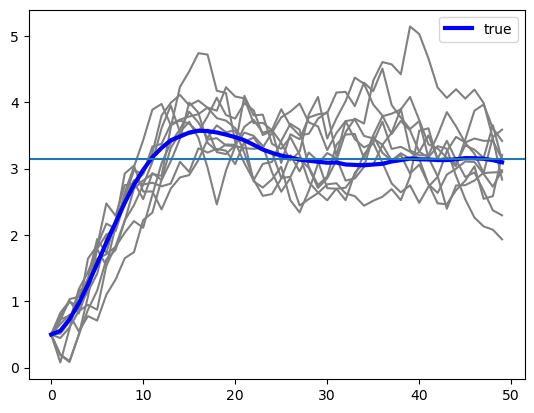

In [36]:
from cps.original_models import *

orig_params = {'T': 50,
               'init_ang': 0.5,
               's0': 46.,
               's1': -23.,
               's2': 0.}

target = 3.14
T = orig_params['T']
        

orig_traj = generate_traj(pid, 500, orig_params)

plot_traj_set(orig_traj, single_traj=10, label='true')
plt.axhline(y=target)


### SOGA program

In [21]:
from optimization import *
import pandas as pd
torch.set_default_dtype(torch.float64)

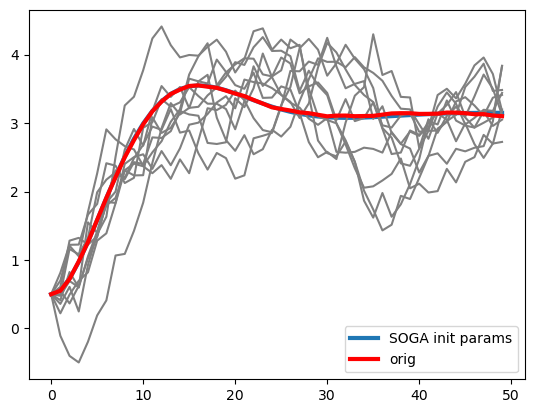

In [22]:
# this is to check that for the correct value of the parameter, the loss is negative and the mean produced by SOGA is almost exactly the true mean

# creates the cfg for the SOGA model
compiledFile=compile2SOGA('../programs/SOGA/Optimization/CaseStudies/PID.soga')
cfg = produce_cfg(compiledFile)
smooth_cfg(cfg)

# initialize parameters
params = {'s0':46., 's1':-23., 's2':0.}
params_dict = initialize_params(params)

# computes SOGA output
output_dist = start_SOGA(cfg, params_dict)

# plot
y_init = output_dist.gm.mean()[:T].detach()
plt.plot(range(T), y_init, lw=3, label='SOGA init params')
plot_traj_set(orig_traj, single_traj=10, color='red', label='orig')
y = []
y_var = []
for i in range(49):
    y.append(output_dist.gm.mean()[output_dist.var_list.index('ang['+ str(i) +']')].detach().numpy())
    y_var.append(torch.sqrt(output_dist.gm.cov()[output_dist.var_list.index('ang['+ str(i) +']'), output_dist.var_list.index('ang['+ str(i) +']')]).detach().numpy())

df = pd.DataFrame({'Y_mean': y, 'Y_std': y_var})
df.to_csv('PID_init.csv', index=False)

s0: 46.199999999546584 s1: -23.199999999335866 s2: -0.1999999936266056  loss: 3093.3936981433335
s0: 46.40000675736757 s1: -23.399927412424304 s2: -0.39991985460015844  loss: 3091.850267587878
s0: 46.60002458968764 s1: -23.599734944223552 s2: -0.5997069098959186  loss: 3090.3145468182174
s0: 46.80005765740048 s1: -23.799376295335424 s2: -0.799309248439481  loss: 3088.7865004484893
s0: 47.0001099563964 s1: -23.99880629320466 s2: -0.9986758751129245  loss: 3087.266087371625
s0: 47.200185308826704 s1: -24.197981015579657 s2: -1.1977568580320397  loss: 3085.753260862333
s0: 47.40028735536745 s1: -24.396857905321014 s2: -1.3965034679516406  loss: 3084.2479687061427
s0: 47.60041954853281 s1: -24.59539587576107 s2: -1.5948683087674425  loss: 3082.7501533534587
s0: 47.800585147074926 s1: -24.7935554059445 s2: -1.7928054382083283  loss: 3081.2597520970967
s0: 48.000787211493936 s1: -24.991298625213854 s2: -1.9902704779491507  loss: 3079.776697271629
s0: 48.201028600668266 s1: -25.18858938674213

Sample:  29%|██▉       | 162/550 [32:57, 12.21s/it, step size=4.00e-13, acc. prob=0.000]


s0: 49.40343710845166 s1: -26.361038610082968 s2: -3.3559481090463565  loss: 3069.5943973005005
s0: 49.60401668093088 s1: -26.5543050615213 s2: -3.5482536253952457  loss: 3068.167162590279
s0: 49.80465114284219 s1: -26.746897033590358 s2: -3.7397704060653356  loss: 3066.746483251788
s0: 50.005341561061556 s1: -26.938795355183135 s2: -3.9304731833113076  loss: 3065.3322563008883
s0: 50.206088822613744 s1: -27.12998271280543 s2: -4.1203386913067845  loss: 3063.924376813993
s0: 50.40689364114661 s1: -27.320443612264754 s2: -4.3093456408573845  loss: 3062.5227382187377
s0: 50.6077565638898 s1: -27.510164333509124 s2: -4.4974746856851935  loss: 3061.1272325785767
s0: 50.808677979018036 s1: -27.69913287938678 s2: -4.6847083810658985  loss: 3059.7377508696472
s0: 51.00965812334063 s1: -27.887338919103506 s2: -4.87103113562168  loss: 3058.354183248639
s0: 51.21069709024141 s1: -28.07477372714899 s2: -5.056429157082171  loss: 3056.9764193103038
s0: 51.41179483779649 s1: -28.26143011844852 s2: -

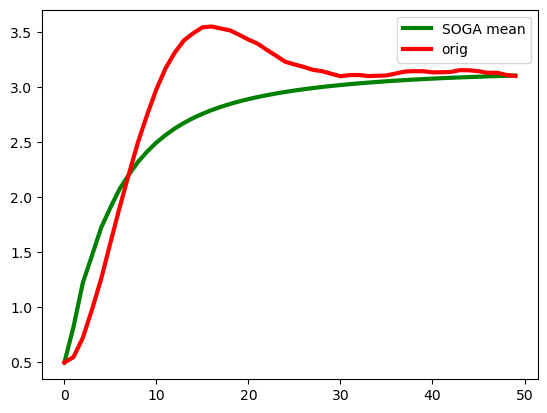

In [23]:
# Trying with neg_log_likelihood as loos

# Optimization in SOGA

# We start from the same initial parameters and try to improve them

# Define loss
observed_traj = target*torch.ones(100, T)
loss = lambda dist : neg_log_likelihood(observed_traj, dist, idx=list(range(1,T)))

# cfg for SOGA
compiledFile=compile2SOGA('../programs/SOGA/Optimization/CaseStudies/PID.soga')
cfg = produce_cfg(compiledFile)
smooth_cfg(cfg)

# initialize parameters
params = {'s0':46., 's1':-23., 's2':0.}
params_dict = initialize_params(params)

# gradient based optimization
loss_list = optimize(cfg, params_dict, loss, n_steps=1000, lr=0.2)

# print results:
for key, value in params_dict.items():
    print(f"{key}: {value.item()}")

# plots the final result
compiledFile=compile2SOGA('../programs/SOGA/Optimization/CaseStudies/PID.soga')
cfg = produce_cfg(compiledFile)
smooth_cfg(cfg)
output_dist = start_SOGA(cfg, params_dict)
plt.plot(range(T), output_dist.gm.mean()[:T].detach(), lw=3, color='green', label='SOGA mean')
plot_traj_set(orig_traj, single_traj=0, color='red', label='orig')
y = []
y_var = []
for i in range(49):
    y.append(output_dist.gm.mean()[output_dist.var_list.index('ang['+ str(i) +']')].detach().numpy())
    y_var.append(torch.sqrt(output_dist.gm.cov()[output_dist.var_list.index('ang['+ str(i) +']'), output_dist.var_list.index('ang['+ str(i) +']')]).detach().numpy())

df = pd.DataFrame({'Y_mean': y, 'Y_std': y_var})
df.to_csv('PID_opt.csv', index=False)

In [24]:
y = []
y_var = []
for i in range(49):
    y.append(output_dist.gm.mean()[output_dist.var_list.index('ang['+ str(i) +']')].detach().numpy())
    y_var.append(torch.sqrt(output_dist.gm.cov()[output_dist.var_list.index('ang['+ str(i) +']'), output_dist.var_list.index('ang['+ str(i) +']')]).detach().numpy())

df = pd.DataFrame({'Y_mean': y, 'Y_std': y_var})
df.to_csv('PID_opt.csv', index=False)

df

,Y_mean,Y_std
0,0.5,0.001414213562373095
1,0.8267247071363777,0.25031587393694354
2,1.2227182008552262,0.3329917256018644
3,1.4715140078823572,0.3794078848791082
4,1.7249549829625377,0.41112561956298804
5,1.9061422405608481,0.4324840118386951
6,2.0748946758339706,0.4480520697946059
7,2.2050681876476403,0.4593047056329621
8,2.3210607939444876,0.4677929973824855
9,2.4147993423629686,0.474201261286429


In [7]:
#export orig_traj to csv
import pandas as pd
#consider only 40 trajectories from time 0 to 30
plot_trajectories = observed_traj[:40, 0:49]
#transpose the array so that each row is a time step and each column is a trajectory
plot_trajectories = plot_trajectories.T

df = pd.DataFrame(plot_trajectories)
df.to_csv('PID_orig_traj.csv', index=False)

ValueError: setting an array element with a sequence.

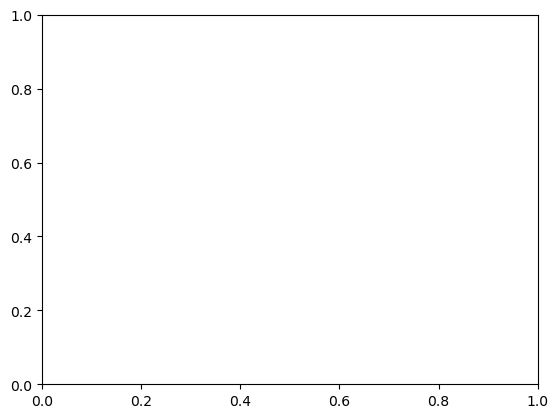

In [10]:
# export loss_list to csv
df_loss = pd.DataFrame({'Loss': loss_list})
df_loss.to_csv('PID_loss.csv', index=False)

#plot

plt.plot(df_loss['Loss'])
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss over iterations')
plt.show()

In [11]:
df_loss

,Loss
0,"[3093.3936981433335, 3091.850267587878, 3090.3..."
1,213.017
2,500


## Pyro

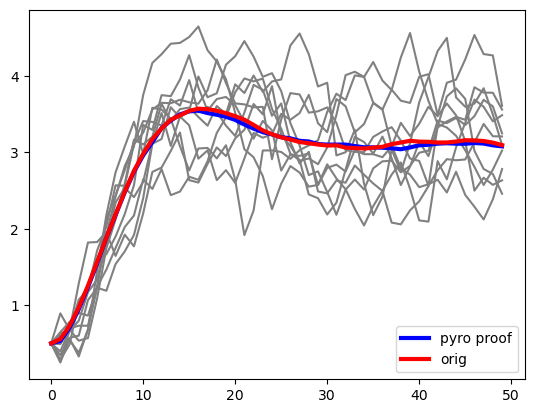

In [37]:
from cps.pyro_models import *

# This is to check that the model works as expected for the right values of the parameters

T = 50
init_ang = 0.5

def pid_pyro_proof(batch_size):

    # Sample parameters
    s0 = pyro.sample("s0", dist.Normal(46., 0.1))
    s1 = pyro.sample("s1", dist.Normal(-23, 0.1))
    s2 = pyro.sample("s2", dist.Normal(0., 0.1))

    target = 3.14
    dt = 0.1
    inertia = 10
    decay = 0.9

    traj_list = []
    v = torch.zeros(batch_size)
    ang = torch.ones(batch_size) * init_ang
    id = torch.zeros(batch_size)

    noise = dist.Normal(0., 0.25)
    noise_ang = dist.Normal(0., 0.25)

    for i in range(T):
        traj_list.append(ang)
        d = target - ang
        torq = s0 * d + s1 * v + s2 * id
        id = decay * id + d * dt
        oldv = v
        v = v + (dt / inertia) * torq + noise.rsample([batch_size])
        ang = ang + (dt / 2) * (v + oldv) + noise_ang.rsample([batch_size])

    traj = torch.stack(traj_list, dim=1)

    return traj

pyro_traj = pid_pyro_proof(batch_size=500)

plot_traj_set(pyro_traj, single_traj=10, label='pyro proof')
plot_traj_set(orig_traj, single_traj=0, color='red', label='orig')

### MCMC

In [27]:
observed_traj = target*torch.ones(100, T) 

init_params = {'T': 50,
               'init_ang': 0.5,
               's0': 46.,
               's1': -23.,
               's2': 0.}


pid_pyro = create_pid_pyro(init_params, eps=2.0)

posterior_samples = run_NUTS(pid_pyro, observed_traj, num_chains=1, num_samples=500, warmup_steps=50, adapt_step_size=True, step_size=1e-4)


Sample: 100%|██████████| 550/550 [00:05, 102.77it/s, step size=4.00e-13, acc. prob=0.001]


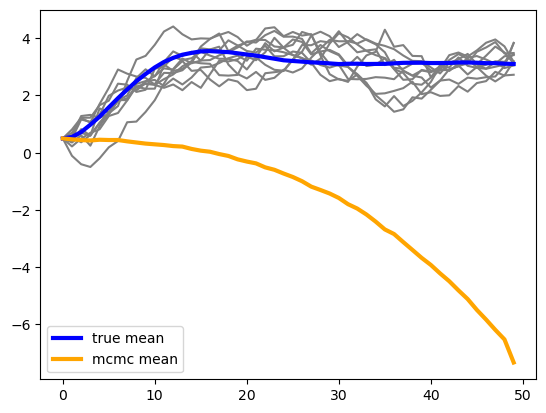

In [28]:
### generate trajectories for posterior estimations and plots the mean trajectory
mcmc_params = {'T': 50,
               'init_ang': 0.5,
               's0': posterior_samples['s0'].mean().item(),
               's1': posterior_samples['s1'].mean().item(),
               's2': posterior_samples['s2'].mean().item()}


mcmc_traj = generate_traj(pid, 100, mcmc_params)

plot_traj_set(orig_traj, single_traj=10, color='blue', label='true mean')
plot_traj_set(mcmc_traj, single_traj=0, color='orange', label='mcmc mean')

### VI Inference

In [38]:
observed_traj = target*torch.ones(100, T) + 0.5*torch.randn(100, T)

init_params = {'T': 50,
               'init_ang': 0.5,
               's0': torch.tensor(46.),
               's1': torch.tensor(-23.),
               's2': torch.tensor(0.)}

Step 0: Loss = 29747.07626452471
Step 100: Loss = 29750.140087549396
Step 200: Loss = 29634.298350630124
Step 300: Loss = 29669.86423852891
Step 400: Loss = 29682.30022793841
Step 500: Loss = 29766.2364525894
Step 600: Loss = 29673.03362614757
Step 700: Loss = 29767.719128702323
Step 800: Loss = 29724.195427513092
Step 900: Loss = 29661.782790898433
Step 1000: Loss = 29663.454431511822
Step 1100: Loss = 29681.10274260637
Step 1200: Loss = 29710.200852258884
Step 1300: Loss = 29727.84362286882
Step 1400: Loss = 29730.405796847703
Step 1500: Loss = 29691.96743091704
Step 1600: Loss = 29620.949548226163
Step 1700: Loss = 29678.776998879235
Step 1800: Loss = 29665.918785700484
Step 1900: Loss = 29677.93428283822
Step 2000: Loss = 29703.2149765414
Step 2100: Loss = 29732.201339081876
Step 2200: Loss = 29705.143468400343
Step 2300: Loss = 29732.069434123572
Step 2400: Loss = 29733.540905605223
Step 2500: Loss = 29740.66303430013
Step 2600: Loss = 29675.05571650692
Step 2700: Loss = 29708.776

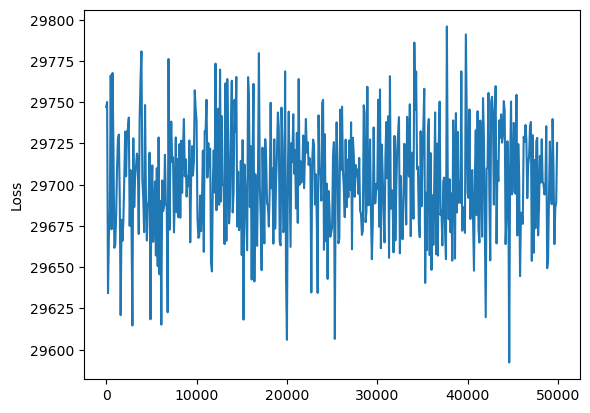

In [48]:
pid_pyro = create_pid_pyro(init_params, eps=1.0)

pid_guide = create_pid_guide(init_params)

run_SVI(pid_pyro, pid_guide, orig_traj, num_steps=50000, lr=0.005, num_particles=10, loss_plot=True)

Optimized s0: 274.6585437222554, s1: -201.99572712441423, s2: 285.03752318028535


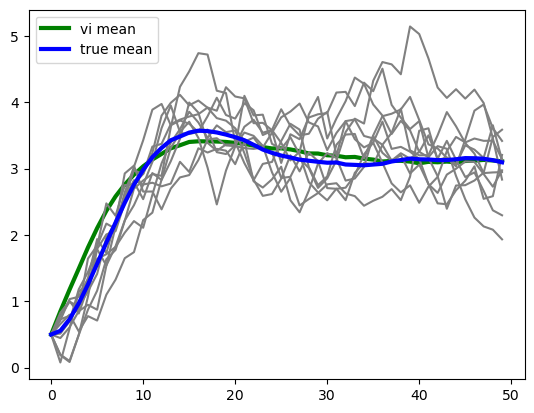

In [52]:
# Retrieve optimized parameters
vi_s0 = pyro.param("s0_loc").item()
vi_s1 = pyro.param("s1_loc").item()
vi_s2 = pyro.param("s2_loc").item()

print(f"Optimized s0: {vi_s0}, s1: {vi_s1}, s2: {vi_s2}")

# plot

vi_traj = generate_traj(pid, 500, {'T': 50,
                                   'init_ang': 0.5,
                                   's0': vi_s0,
                                   's1': vi_s1,
                                   's2': vi_s2})

plot_traj_set(vi_traj, single_traj=0, color='green', label='vi mean')
plot_traj_set(orig_traj, single_traj=10, color='blue', label='true mean')


In [53]:
# Compute mean and std of the trajectories generated with VI parameters 
y = []
y_var = []
for i in range(49):
    y.append(vi_traj[:, i].mean().item())
    y_var.append(vi_traj[:, i].std().item())
df = pd.DataFrame({'Y_mean': y, 'Y_std': y_var})
df.to_csv('PID_VI.csv', index=False)

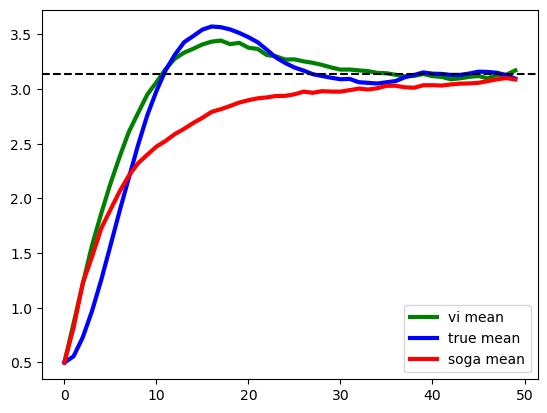

In [54]:
vi_traj = generate_traj(pid, 500, {'T': 50,
                                   'init_ang': 0.5,
                                   's0': vi_s0,
                                   's1': vi_s1,
                                   's2': vi_s2})

soga_traj = generate_traj(pid, 500, {'T': 50,
                                     'init_ang': 0.5,
                                     's0': params_dict['s0'].item(),
                                     's1': params_dict['s1'].item(),
                                     's2': params_dict['s2'].item()})

plot_traj_set(vi_traj, single_traj=0, color='green', label='vi mean')
plot_traj_set(orig_traj, single_traj=0, color='blue', label='true mean')
plot_traj_set(soga_traj, single_traj=0, color='red', label='soga mean')
plt.axhline(y=target, color='black', linestyle='--', label='target')

In [34]:
# Retrieve optimized mean and variance of paramters from VI and calculate the negative log likelihood of the observed data given the optimized parameters
vi_s0_mean = pyro.param("s0_loc").item()
vi_s0_std = pyro.param("s0_scale").item()
vi_s1_mean = pyro.param("s1_loc").item()
vi_s1_std = pyro.param("s1_scale").item()
vi_s2_mean = pyro.param("s2_loc").item()
vi_s2_std = pyro.param("s2_scale").item()
print(f"VI optimized parameters: s0 = {vi_s0_mean} ± {vi_s0_std}, s1 = {vi_s1_mean} ± {vi_s1_std}, s2 = {vi_s2_mean} ± {vi_s2_std}")

#now calculate the negative log likelihood of the observed data given the optimized parameters


KeyError: 's0_scale'